## **Project: Cell body segmentation prediction using machine learning**
- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340
- **Date**: 02/10/2025
- **Goal**: Create a basic prediction model and a feature explainer

In [9]:
import logging 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)


### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [10]:
df_raw = pd.read_csv('../data/raw/skbr_cells.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [11]:
df_raw.sample(10,random_state=2025)


,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1526,208336841,Train,WS,148.157960,308,118.761905,197.187075,70.027211,112.697279,1.065898,...,34916,57680,20588,33133,48.976509,156.199809,104.811623,18.749445,460,188
1551,208396157,Test,PS,10.346789,242,58.722944,6.909091,77.497835,3.194805,1.231397,...,13565,1366,17902,738,68.858858,171.501111,3.662276,15.203546,201,399
552,208312454,Test,PS,109.824389,160,61.143791,4.712418,147.366013,34.052288,1.167683,...,9355,569,22547,5210,37.426777,91.057243,46.012188,12.061842,216,163
1956,208935209,Train,PS,164.907580,153,25.719178,115.417808,26.904110,86.863014,1.179153,...,3755,16706,3928,12682,16.221389,26.463293,58.400909,11.939754,269,107
135,208406905,Test,WS,143.244805,246,23.834043,246.068085,10.506383,43.165957,1.097487,...,5601,57592,2469,10144,17.349784,25.911859,66.686581,15.969757,494,64
571,208405358,Test,PS,111.650507,293,37.342857,4.432143,83.782143,54.010714,1.413115,...,10456,962,23459,15123,21.287747,43.671653,69.855283,9.123565,114,236
325,208410525,Test,WS,83.976225,316,39.970199,140.996689,47.619205,66.612583,1.089897,...,12071,42280,14381,20117,28.215745,47.378328,65.185463,13.399715,275,84
723,208406924,Test,PS,108.271419,563,20.990706,62.881041,25.752788,13.386617,1.595038,...,11293,33293,13855,7202,17.458658,33.273512,28.350160,27.449929,387,152
1056,208396138,Train,PS,19.550427,412,214.098985,328.918782,238.106599,446.873096,1.136391,...,84355,129201,93814,176068,164.607880,321.653823,376.531983,22.847778,111,303
411,208397497,Train,PS,86.122381,310,95.827703,136.952703,171.847973,568.989865,1.124491,...,28365,40243,50867,168421,54.252295,137.681847,361.835294,16.429758,210,307


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [12]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking = df_baking[['case','perimch1','eqsphereareach1','entropyintench1', 'class']]
df_baking['class'] = df_baking['class'].astype('category')
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   case             2019 non-null   object  
 1   perimch1         2019 non-null   float64 
 2   eqsphereareach1  2019 non-null   float64 
 3   entropyintench1  2019 non-null   float64 
 4   class            2019 non-null   category
dtypes: category(1), float64(3), object(1)
memory usage: 65.3+ KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [13]:
df_train = df[df['case']=='Train']
df_test = df[df['case']=='Test']
df_train = df_train.drop(columns=['case'])
df_test = df_test.drop(columns=['case'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 1 to 2018
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   perimch1         1009 non-null   float64 
 1   eqsphereareach1  1009 non-null   float64 
 2   entropyintench1  1009 non-null   float64 
 3   class            1009 non-null   category
dtypes: category(1), float64(3)
memory usage: 32.6 KB


In [14]:
display(df_train.describe().T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1009.0,91.606820,41.962245,47.737594,64.366964,79.021475,103.241588,459.765378
eqsphereareach1,1009.0,1302.497250,866.220998,603.755102,779.850340,1027.222222,1505.195011,8746.063492
entropyintench1,1009.0,6.601351,0.759235,4.707829,6.043644,6.581075,7.081551,9.475700


,count,unique,top,freq
class,1009,2,PS,636


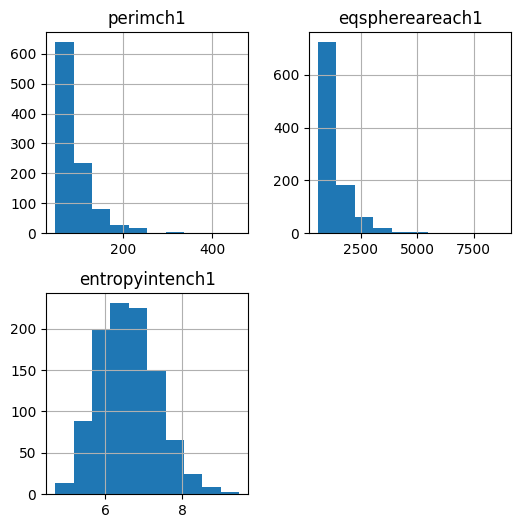

In [15]:
#analysis univariado

df_train.hist(figsize=(6,6))
plt.show()

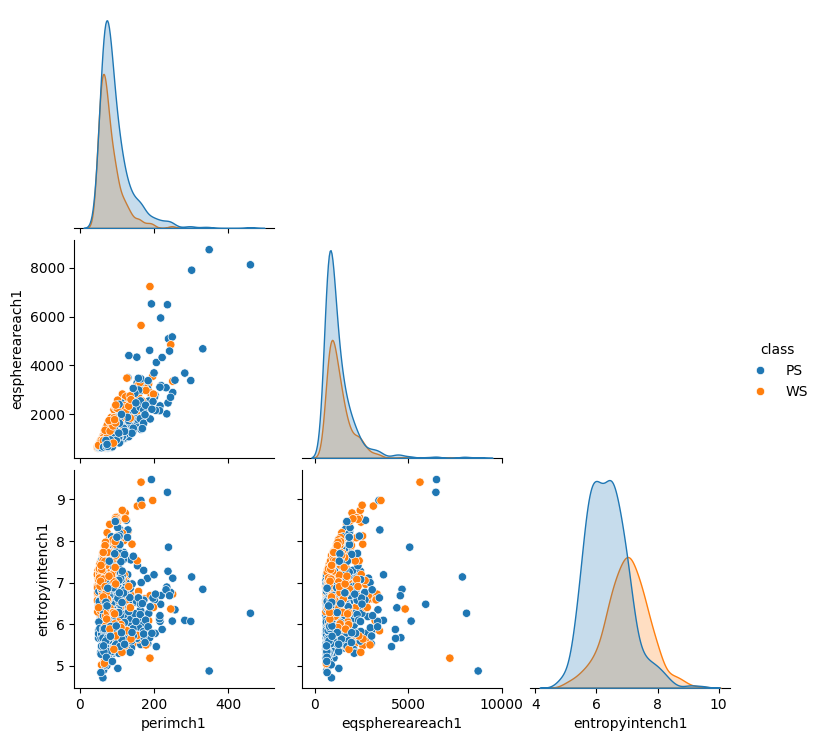

In [16]:
# Analysis Bivariado
sns.pairplot(data=df_train, hue='class', corner=True)
plt.show()

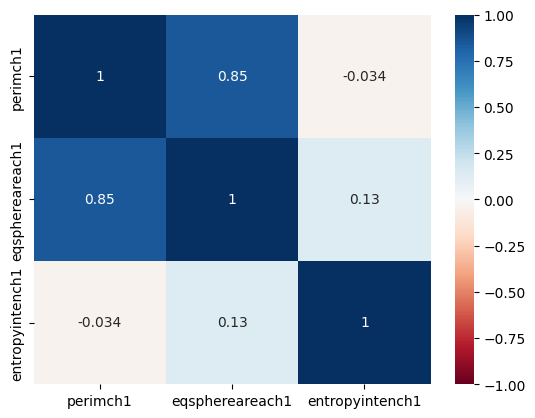

In [17]:
#coorelation
sns.heatmap(data=df_train.select_dtypes('number').corr(),vmin=-1,vmax=1,cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [18]:
X_train = df_train[['entropyintench1','perimch1','eqsphereareach1']].copy()
y_train = df_train['class'].copy()
X_test = df_test[['entropyintench1','perimch1','eqsphereareach1']].copy()
y_test = df_test['class'].copy()

Below is only w/ Classification

In [19]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [20]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train_enc)

DecisionTreeClassifier()

In [21]:
y_hat = clf_tree.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat):.2f}')

accuracy: 0.72


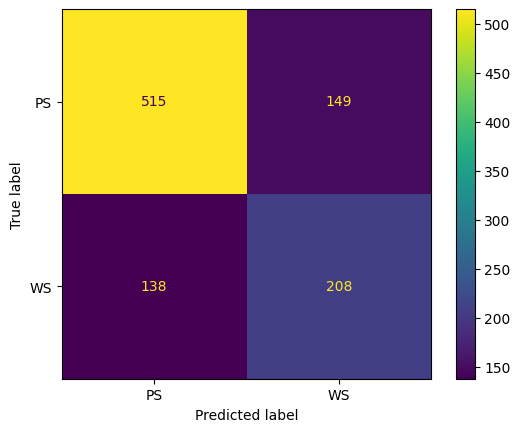

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=label_encoder.classes_)
plt.show()

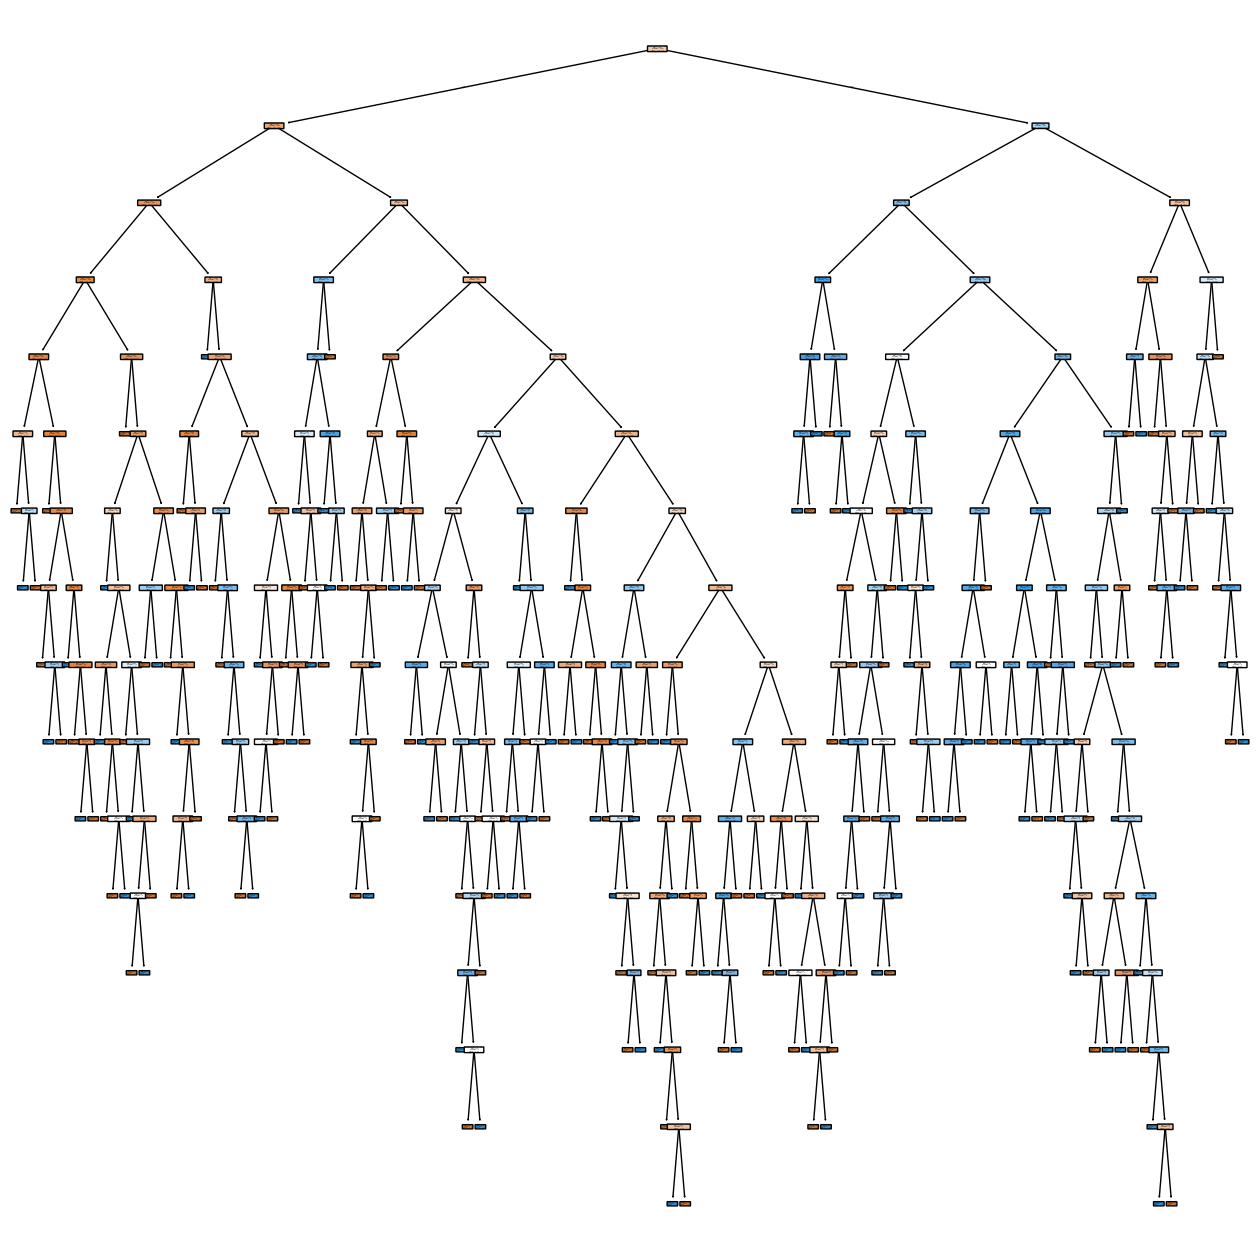

In [23]:
plt.figure(figsize=(16,16))
plot_tree(clf_tree,filled=True,feature_names=X_train.columns,rounded=True)
plt.show()